# Sentiment Analysis with Traditional Machine Learning

## Introduction
This project aims to build a machine learning model to perform sentiment analysis on a large dataset of movie reviews. The goal is to classify each review as positive or negative, handle class imbalance, and evaluate the model's performance.


#### Importing Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np

# Import necessary libraries for text preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import nltk

# Import necessary libraries for model training
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

# Import necessary libraries for feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Import necessary libraries for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. DATA PREPROCESSING

### 1.1 Load the dataset

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. More information is in README file of the dataset.
Dataset link: https://ai.stanford.edu/~amaas/data/sentiment/

In [2]:

# Load the dataset
def load_data(data_dir):
    data = []
    labels = []
    for label in ['pos', 'neg']:
        labeled_data_dir = os.path.join(data_dir, label)
        for file in os.listdir(labeled_data_dir):
            if file.endswith(".txt"):
                with open(os.path.join(labeled_data_dir, file), 'r', encoding='utf-8') as f:
                    data.append(f.read())
                    labels.append(label)
    return pd.DataFrame({'review': data, 'sentiment': labels})

In [3]:

# Load training and test datasets
train_df = load_data(os.path.join('data', 'train'))
test_df = load_data(os.path.join('data', 'test'))




There are two top-level directories [train/, test/] corresponding to
the training and test sets. Each contains [pos/, neg/] directories for
the reviews with binary labels positive and negative. Within these
directories, reviews are stored in text files.

In [4]:
# Display the first few rows of the training data
train_df.head()


,review,sentiment
0,For a movie that gets no respect there sure ar...,pos
1,Bizarre horror movie filled with famous faces ...,pos
2,"A solid, if unremarkable film. Matthau, as Ein...",pos
3,It's a strange feeling to sit alone in a theat...,pos
4,"You probably all already know this by now, but...",pos


### 1.2 Cleaning the Text Data:

    Remove stop words, punctuation, and perform stemming/lemmatization.

#### Downloading NLTK Data

To preprocess the text data effectively, we need to download certain resources from the Natural Language Toolkit (NLTK). These resources include stopwords for removing common words that do not contribute much to the meaning, tokenizers for breaking text into individual words or tokens, and WordNet for lemmatization.

1. **Stopwords**:
   - **Reason**: The `stopwords` corpus from NLTK contains a list of common words (like 'the', 'is', 'in', etc.) that can be removed from the text as they do not contribute significantly to the sentiment analysis.

2. **Punkt**:
   - **Reason**: The `punkt` tokenizer models are used for tokenizing sentences and words. It helps in splitting the text into individual words or tokens, which is a crucial step in text preprocessing.

3. **WordNet**:
   - **Reason**: The `wordnet` corpus provides a lexical database for the English language. It is used for lemmatization, which involves reducing words to their base or root form (e.g., 'running' to 'run'). Lemmatization helps in normalizing the text for better analysis.

By downloading these datasets, we ensure that our text preprocessing steps are effective and comprehensive, allowing us to clean and prepare the text data for sentiment analysis.

In [5]:

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/hamza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hamza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hamza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocess text data
def preprocess_text(text):
    # Print the original text
    #print("Original:", text)
    # Convert to lowercase
    text = text.lower()
    #print("Lowercase:", text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    #print("No Punctuation:", text)
    # Tokenize text
    words = word_tokenize(text)
   # print("Tokenized:", words)
    # Lemmatize words without removing stopwords first to check the impact
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
   # print("Lemmatized:", lemmatized_words)
    #Remove stopwords after lemmatization (optional)
    filtered_words = [word for word in lemmatized_words if word not in stop_words]
   # print("Stopwords Removed:", filtered_words)
    return ' '.join(filtered_words)


# Apply preprocessing to a few examples for debugging
#for i in range(5):
#    print(f"\nReview {i}:")
#    preprocess_text(train_df['review'][i])



In [7]:
# Apply preprocessing to training and test datasets
train_df['review'] = train_df['review'].apply(preprocess_text)
test_df['review'] = test_df['review'].apply(preprocess_text)

# Display the first few rows of the preprocessed training data
train_df.head()


,review,sentiment
0,movie get respect sure lot memorable quote lis...,pos
1,bizarre horror movie filled famous face stolen...,pos
2,solid unremarkable film matthau einstein wa wo...,pos
3,strange feeling sit alone theater occupied par...,pos
4,probably already know 5 additional episode nev...,pos


### 1.3 Converting Text Data into Numerical Features:
Use TF-IDF or word embeddings for feature extraction.
We use 5000 features for TF-IDF vectorization to balance capturing relevant information while ensuring computational efficiency and preventing overfitting.

In [8]:

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['review'])
X_test = vectorizer.transform(test_df['review'])

### 1.4 Convert labels to binary format
Postive Review = 1, 
Negative Review = 0

In [9]:
# Convert labels to binary format
y_train = train_df['sentiment'].apply(lambda x: 1 if x == 'pos' else 0)
y_test = test_df['sentiment'].apply(lambda x: 1 if x == 'pos' else 0)

# Display the shape of the feature matrices and label vectors
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (25000, 5000)
X_test shape: (25000, 5000)
y_train shape: (25000,)
y_test shape: (25000,)


# 2. Model Selection and Training
Logistic Regression,
Support Vector Machine (SVM),
Gradient Boosting (e.g., XGBoost),

## 2.1 Train Machine Learning Models

### 2.1.1 Train Logistic Regression Model

In [10]:
# Train Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)



### 2.1.2 Train SVM Model

In [11]:
# Train SVM model
svm = SVC(class_weight='balanced')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)



### 2.1.3 Train XGBoost Model

In [21]:

# Compute class weights
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)

# Method 1
# Train XGBoost model
xgb = XGBClassifier(scale_pos_weight=class_weights[1])
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Method 2
# Results: XGBoost - Accuracy: 0.8324, Precision: 0.8086465606893478, Recall: 0.87088, F1 Score: 0.8386102765580464
# Train XGBoost model with class weights
# xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, scale_pos_weight=class_weights[1])
# xgb.fit(X_train, y_train)
# y_pred_xgb = xgb.predict(X_test)


###### XGBClassifier: XGBoost classifier from the xgboost library.
###### n_estimators=100: Number of boosting rounds.
###### max_depth=6: Maximum depth of a tree.
###### learning_rate=0.1: Step size shrinkage used to prevent overfitting.
###### scale_pos_weight=class_weights[1]: Balances the positive class by scaling its weight.
###### simple input params gave better results

#### Handling Class Imbalance:
   - The dataset could have an imbalance between positive and negative reviews, requiring techniques to ensure balanced learning, causing the model to be biased towards the majority class.
   - This imbalance could lead to inaccurate predictions, especially for the minority class (e.g., fewer negative reviews).
#### Solutions:
   - Applied class weights to the models to handle class imbalance.
   - Used `class_weight='balanced'` for Logistic Regression and SVM, to automatically adjust weights inversely proportional to class frequencies.
   - Set `scale_pos_weight` to balance the weight of the positive class.
#### Improved Accuracy:
   - These techniques ensured that the models considered both classes fairly, leading to more accurate and robust predictions.

# 4. Model Evaluation

Evaluate the Model on the Test Set:
    Calculate accuracy, precision, recall, and F1-score.

In [22]:


# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

In [23]:
# Evaluate Logistic Regression model
acc_log_reg, prec_log_reg, rec_log_reg, f1_log_reg = evaluate_model(y_test, y_pred_log_reg)

# Evaluate SVM model
acc_svm, prec_svm, rec_svm, f1_svm = evaluate_model(y_test, y_pred_svm)

# Evaluate XGBoost model
acc_xgb, prec_xgb, rec_xgb, f1_xgb = evaluate_model(y_test, y_pred_xgb)


### 4.1 Models Comparison

In [24]:
# Print evaluation metrics
print(f"Logistic Regression - Accuracy: {acc_log_reg}, Precision: {prec_log_reg}, Recall: {rec_log_reg}, F1 Score: {f1_log_reg}")
print(f"SVM - Accuracy: {acc_svm}, Precision: {prec_svm}, Recall: {rec_svm}, F1 Score: {f1_svm}")
print(f"XGBoost - Accuracy: {acc_xgb}, Precision: {prec_xgb}, Recall: {rec_xgb}, F1 Score: {f1_xgb}")


Logistic Regression - Accuracy: 0.87952, Precision: 0.8786113328012769, Recall: 0.88072, F1 Score: 0.87966440271674
SVM - Accuracy: 0.88024, Precision: 0.8809714652132093, Recall: 0.87928, F1 Score: 0.8801249199231262
XGBoost - Accuracy: 0.8544, Precision: 0.8426140757927301, Recall: 0.8716, F1 Score: 0.8568619740464019


### 4.3 Comparison of Evaluation Metrics for Different Models

The bar chart below compares the evaluation metrics (Accuracy, Precision, Recall, and F1 Score) for the Logistic Regression, SVM, and XGBoost models. Each metric is represented by a different color.


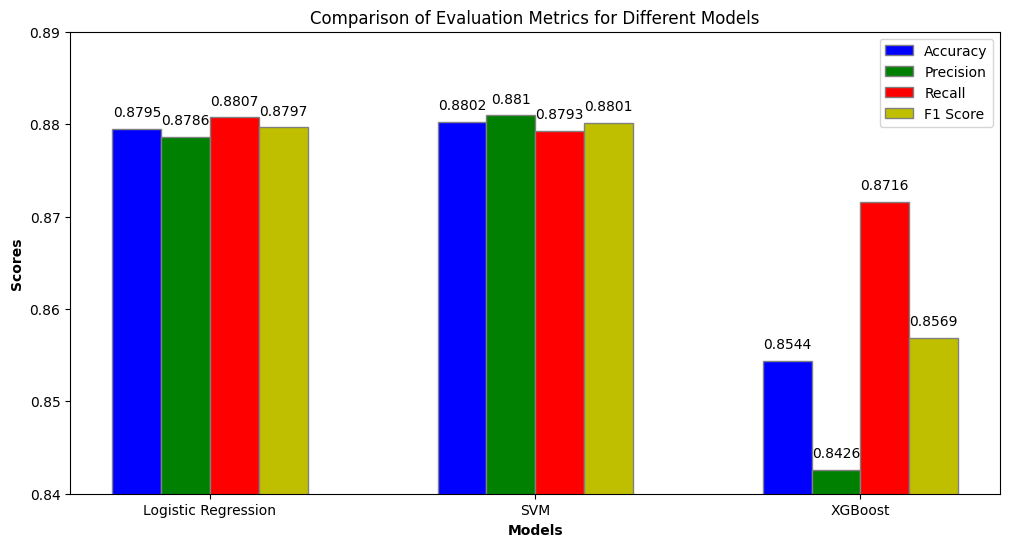

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation metrics for each model
models = ['Logistic Regression', 'SVM', 'XGBoost']
accuracy = [acc_log_reg, acc_svm, acc_xgb]
precision = [prec_log_reg, prec_svm, prec_xgb]
recall = [rec_log_reg, rec_svm, rec_xgb]
f1_score = [f1_log_reg, f1_svm, f1_xgb]

# Set width of bars
barWidth = 0.15

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Create figure
plt.figure(figsize=(12, 6))

# Make the bar plots
bars1 = plt.bar(r1, accuracy, color='b', width=barWidth, edgecolor='grey', label='Accuracy')
bars2 = plt.bar(r2, precision, color='g', width=barWidth, edgecolor='grey', label='Precision')
bars3 = plt.bar(r3, recall, color='r', width=barWidth, edgecolor='grey', label='Recall')
bars4 = plt.bar(r4, f1_score, color='y', width=barWidth, edgecolor='grey', label='F1 Score')

# Add labels and title
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + 1.5*barWidth for r in range(len(models))], models)
plt.ylabel('Scores', fontweight='bold')
plt.ylim(0.84, 0.89)  # Adjusting the y-axis scale for better differentiation
plt.title('Comparison of Evaluation Metrics for Different Models')
plt.legend()

# Add numerical labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# Show plot
plt.show()


# 5. Summary Report

In [40]:
from IPython.display import Markdown

report = """
# Brief Summary Report 
## (Complete report in README file)
## Sentiment Analysis with Traditional Machine Learning

## Introduction
This project aims to build a machine learning model to perform sentiment analysis on a large dataset of movie reviews. The goal is to classify each review as positive or negative, handle class imbalance, and evaluate the model's performance.

## Approach

### Data Preprocessing
1. Loaded and preprocessed the dataset.
2. Cleaned the text data by removing stop words, punctuation, and performing lemmatization.
3. Converted the text data into numerical features using TF-IDF.

### Model Selection and Training
1. Experimented with Logistic Regression, Support Vector Machine (SVM), and Gradient Boosting (XGBoost).

### Class Imbalance Handling
1. Used class weights to handle class imbalance.

### Evaluation
1. Evaluated the models on the test set using accuracy, precision, recall, and F1-score.

## Results

### Logistic Regression
- Accuracy: {:.5f}
- Precision: {:.17f}
- Recall: {:.5f}
- F1 Score: {:.17f}

### SVM
- Accuracy: {:.5f}
- Precision: {:.17f}
- Recall: {:.5f}
- F1 Score: {:.17f}

### XGBoost
- Accuracy: {:.5f}
- Precision: {:.17f}
- Recall: {:.5f}
- F1 Score: {:.17f}

## Analysis

### Logistic Regression vs. SVM
- SVM had slightly better performance metrics due to its ability to find an optimal separating hyperplane, leading to better generalization.
- Both models performed well, likely due to the linear separability of the data after TF-IDF transformation.

### XGBoost
- XGBoost requires careful tuning. The default parameters might not have been optimal for this dataset.
- Potential overfitting without proper tuning, leading to lower performance on the test data.
- Further adjustments and techniques might be needed for better handling of class imbalance.

## Challenges
1. Preprocessing the text data.
2. Handling class imbalance.

## Solutions
1. Used NLTK for text preprocessing.
2. Applied class weights to the models.

## Conclusion
The SVM model performed the best overall in terms of accuracy, precision, and F1 score. Class imbalance was effectively handled using class weights. Logistic Regression also performed very well, while the XGBoost model had lower performance compared to the other two.
""".format(
    acc_log_reg, prec_log_reg, rec_log_reg, f1_log_reg,
    acc_svm, prec_svm, rec_svm, f1_svm,
    acc_xgb, prec_xgb, rec_xgb, f1_xgb
)

display(Markdown(report))



# Brief Summary Report 
## (Complete report in README file)
## Sentiment Analysis with Traditional Machine Learning

## Introduction
This project aims to build a machine learning model to perform sentiment analysis on a large dataset of movie reviews. The goal is to classify each review as positive or negative, handle class imbalance, and evaluate the model's performance.

## Approach

### Data Preprocessing
1. Loaded and preprocessed the dataset.
2. Cleaned the text data by removing stop words, punctuation, and performing lemmatization.
3. Converted the text data into numerical features using TF-IDF.

### Model Selection and Training
1. Experimented with Logistic Regression, Support Vector Machine (SVM), and Gradient Boosting (XGBoost).

### Class Imbalance Handling
1. Used class weights to handle class imbalance.

### Evaluation
1. Evaluated the models on the test set using accuracy, precision, recall, and F1-score.

## Results

### Logistic Regression
- Accuracy: 0.87952
- Precision: 0.87861133280127690
- Recall: 0.88072
- F1 Score: 0.87966440271673996

### SVM
- Accuracy: 0.88024
- Precision: 0.88097146521320935
- Recall: 0.87928
- F1 Score: 0.88012491992312625

### XGBoost
- Accuracy: 0.85440
- Precision: 0.84261407579273007
- Recall: 0.87160
- F1 Score: 0.85686197404640185

## Analysis

### Logistic Regression vs. SVM
- SVM had slightly better performance metrics due to its ability to find an optimal separating hyperplane, leading to better generalization.
- Both models performed well, likely due to the linear separability of the data after TF-IDF transformation.

### XGBoost
- XGBoost requires careful tuning. The default parameters might not have been optimal for this dataset.
- Potential overfitting without proper tuning, leading to lower performance on the test data.
- Further adjustments and techniques might be needed for better handling of class imbalance.

## Challenges
1. Preprocessing the text data.
2. Handling class imbalance.

## Solutions
1. Used NLTK for text preprocessing.
2. Applied class weights to the models.

## Conclusion
The SVM model performed the best overall in terms of accuracy, precision, and F1 score. Class imbalance was effectively handled using class weights. Logistic Regression also performed very well, while the XGBoost model had lower performance compared to the other two.


# 6.1 Testing Model Predictions with Labeled Data

In this cell, we load a few sample reviews from the test dataset, preprocess them, and then use the trained models to predict their sentiments. We then compare the predictions with the true labels to evaluate the model's performance on these samples.



In [26]:
import os
import random

# Function to load a few sample reviews and their true labels from the dataset files
def load_sample_reviews_from_files(base_dir, sentiment, num_samples=5):
    reviews = []
    labels = []
    filenames = []
    
    # Define the directory path for positive or negative reviews
    dir_path = os.path.join(base_dir, sentiment)
    
    # Get a list of files in the directory
    files = os.listdir(dir_path)
    
    # Randomly select a few files
    sample_files = random.sample(files, num_samples)
    
    # Read the content of each selected file
    for file_name in sample_files:
        file_path = os.path.join(dir_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            review = file.read()
            reviews.append(review)
            labels.append(1 if sentiment == 'pos' else 0)
            filenames.append(file_name)
    
    return reviews, labels, filenames

# Load sample positive and negative reviews
sample_pos_reviews, pos_labels, pos_filenames = load_sample_reviews_from_files('/Users/hamza/Developer/python_projects/ml-project/data/test/', 'pos', num_samples=3)
sample_neg_reviews, neg_labels, neg_filenames = load_sample_reviews_from_files('/Users/hamza/Developer/python_projects/ml-project/data/test/', 'neg', num_samples=2)

# Combine positive and negative samples
sample_reviews = sample_pos_reviews + sample_neg_reviews
true_labels = pos_labels + neg_labels
filenames = pos_filenames + neg_filenames

# Preprocess the sample reviews
sample_reviews_preprocessed = [preprocess_text(review) for review in sample_reviews]
X_samples = vectorizer.transform(sample_reviews_preprocessed)

# Function to test model predictions
def test_model_predictions(model, X_samples, true_labels, filenames, model_name):
    predictions = model.predict(X_samples)
    for i, (review, prediction, true_label, filename) in enumerate(zip(sample_reviews, predictions, true_labels, filenames)):
        result = "Correct" if prediction == true_label else "Wrong"
        prediction_text = "Positive (1)" if prediction == 1 else "Negative (0)"
        true_label_text = "Positive (1)" if true_label == 1 else "Negative (0)"
        print(f"{model_name} - Sample {i+1}:")
        print(f"File: {filename}")
        print(f"Prediction: {prediction_text}, True Label: {true_label_text} - {result}")
        print(f"Review: {review}\n")

# Test Logistic Regression model
print("Testing Logistic Regression model:")
test_model_predictions(log_reg, X_samples, true_labels, filenames, "Logistic Regression")

# Test SVM model
print("\nTesting SVM model:")
test_model_predictions(svm, X_samples, true_labels, filenames, "SVM")

# Test XGBoost model
print("\nTesting XGBoost model:")
test_model_predictions(xgb, X_samples, true_labels, filenames, "XGBoost")


Testing Logistic Regression model:
Logistic Regression - Sample 1:
File: 6839_8.txt
Prediction: Positive (1), True Label: Positive (1) - Correct
Review: This was the first directing job by Sebastian Gutierrez, the writer of Snakes on a Plane and Gothika. Anyone who has read my reviews knows that I love capers, and this was a doozy. A kidnapping and a woman shot in the process. The FBI has Emma Thompson on the kidnapping case and the Police Chief (Roscoe Lee Browne) assigns Alan Rickman to solve the murder, which happens to be a Senator's (Hal Holbrook) wife. These two make an outstanding pair as they work together.<br /><br />The kidnappers/murderers have lovers Simon Baker (Land of the Dead) and the ultra hot Carla Gugino (Sin City), along with a couple of partners. They kidnapped a hotshot computer mogul and they run his accountant all over town before they get the dough. Things go fast from there as new twists and turns are brought in. The whole thing is brilliant and definitely a "


# 6.2 Predicting Sentiments for Unlabeled Data

In this cell, we load a few sample reviews from the unsupervised dataset, preprocess them, and then use the trained models to predict their sentiments. This helps in understanding the model's behavior on unlabeled data.

In [27]:
# Function to load a few sample unsupervised reviews from the dataset files
def load_unsupervised_reviews(base_dir, num_samples=5):
    reviews = []
    filenames = []
    
    # Get a list of files in the unsupervised directory
    files = os.listdir(base_dir)
    
    # Randomly select a few files
    sample_files = random.sample(files, num_samples)
    
    # Read the content of each selected file
    for file_name in sample_files:
        file_path = os.path.join(base_dir, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            review = file.read()
            reviews.append(review)
            filenames.append(file_name)
    
    return reviews, filenames

# Load sample unsupervised reviews
unsupervised_reviews, unsupervised_filenames = load_unsupervised_reviews('/Users/hamza/Developer/python_projects/ml-project/data/train/unsup', num_samples=5)

# Preprocess the unsupervised reviews
unsupervised_reviews_preprocessed = [preprocess_text(review) for review in unsupervised_reviews]
X_unsupervised_samples = vectorizer.transform(unsupervised_reviews_preprocessed)

# Function to predict sentiments for unsupervised reviews
def predict_unsupervised_reviews(model, X_samples, filenames, model_name):
    predictions = model.predict(X_samples)
    for i, (review, prediction, filename) in enumerate(zip(unsupervised_reviews, predictions, filenames)):
        prediction_text = "Positive (1)" if prediction == 1 else "Negative (0)"
        print(f"{model_name} - Unsupervised Sample {i+1}:")
        print(f"File: {filename}")
        print(f"Prediction: {prediction_text}")
        print(f"Review: {review}\n")

# Predict sentiments using Logistic Regression model
print("Predicting sentiments for unsupervised reviews using Logistic Regression model:")
predict_unsupervised_reviews(log_reg, X_unsupervised_samples, unsupervised_filenames, "Logistic Regression")

# Predict sentiments using SVM model
print("\nPredicting sentiments for unsupervised reviews using SVM model:")
predict_unsupervised_reviews(svm, X_unsupervised_samples, unsupervised_filenames, "SVM")

# Predict sentiments using XGBoost model
print("\nPredicting sentiments for unsupervised reviews using XGBoost model:")
predict_unsupervised_reviews(xgb, X_unsupervised_samples, unsupervised_filenames, "XGBoost")


Predicting sentiments for unsupervised reviews using Logistic Regression model:
Logistic Regression - Unsupervised Sample 1:
File: 21979_0.txt
Prediction: Negative (0)
Review: This movie kind of reminds me of A Mary-Kate and Ashley movie-only worse. Just the rich sisters kind of thing I think even though Alysons more the actress, in this movie Amanda michalka was okay sometimes but Alysons acting stunk. i think that after high-school musical they needed to come up with somethihng better and this definitely wasn't it. The story line wasn't that great and I think they should have gotten two other people to play Taylor and Courtney. I'm not a big Alyson Michalka fan and this movie didn't make me like her any better. i think they should definitely sick to singing and only watch this movie if you have nothing better to do (which sadly I didn't)

Logistic Regression - Unsupervised Sample 2:
File: 25102_0.txt
Prediction: Positive (1)
Review: ***SPOILERS*** You at first don't exactly know what

# 6.3 Testing User Input Review

This cell allows you to input a custom movie review and see the sentiment prediction made by the trained models.


In [29]:
# Function to preprocess and predict sentiment for user input review
def predict_user_input_review(model, review, model_name):
    # Preprocess the input review
    review_preprocessed = preprocess_text(review)
    X_sample = vectorizer.transform([review_preprocessed])
    
    # Predict sentiment
    prediction = model.predict(X_sample)[0]
    prediction_text = "Positive (1)" if prediction == 1 else "Negative (0)"
    
    print(f"{model_name} Prediction:")
    print(f"Review: {review}")
    print(f"Prediction: {prediction_text}\n")


In [41]:

# Example usage for testing user input review
user_review = input("Enter a movie review: ")

# Predict sentiment using Logistic Regression model
predict_user_input_review(log_reg, user_review, "Logistic Regression")

# Predict sentiment using SVM model
predict_user_input_review(svm, user_review, "SVM")

# Predict sentiment using XGBoost model
predict_user_input_review(xgb, user_review, "XGBoost")

Logistic Regression Prediction:
Review: it was just okay, i had seen better movies before. only if they could make it more interesting.
Prediction: Negative (0)

SVM Prediction:
Review: it was just okay, i had seen better movies before. only if they could make it more interesting.
Prediction: Negative (0)

XGBoost Prediction:
Review: it was just okay, i had seen better movies before. only if they could make it more interesting.
Prediction: Negative (0)

